In [ ]:
import torch
import torch.autograd as autograd   # computation graph
from torch.autograd import Variable
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim
import datetime, os

#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import time
#from pyDOE import lhs         #Latin Hypercube Sampling

# generates same random numbers each time
np.random.seed(1234)

n_points = 151
x = np.linspace(-np.pi,np.pi,n_points)

lb = -np.pi
ub = -np.pi/3



def u_sol(x):
    f = 0
    for k in range(1,6):
        f += np.sin(2*k*x)/(2*k)
    return f
        
u = u_sol(x)

def u_de(x):
    
    f_prime = 0
    f_second = 0
    f_third = 0
    f_fourth = 0
    
    for k in range(1,6):
        
        f_prime += np.cos(2*k*x)
        f_second += -2*k*np.sin(2*k*x)
        f_third += -4*(k**2)*np.cos(2*k*x)
        f_fourth += 8*(k**3)*np.sin(2*k*x)
        
    return f_prime, f_second, f_third, f_fourth

u_prime, u_second, u_third, u_fourth = u_de(x)


###################
#### TEST DATA ####
###################

X_u_test = x.reshape(n_points,1)

u = u.reshape(n_points,1)



results_name = 'left_domain_6L_20N_Adam'
#results_name = 'Oscillator_1L_50N_Adam'
split_results_name = 'left_domain_smallest_'
number_of_neurons = [10, 20, 50, 100, 200, 400]
number_of_layers = 1

time_plot_avg = np.array([0, 0, 0, 0, 0, 0])
gen_level_plot = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

time_plot_std = np.array([0, 0, 0, 0, 0, 0])



all_u_pred = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_' + results_name + '/MGP_all_U_pred_' + results_name, delimiter = ',' )
all_u_pred_x = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_prime_' + results_name + '/MGP_all_U_pred_prime_' + results_name, delimiter = ',' )

all_u_pred_xx = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_second_' + results_name + '/MGP_all_U_pred_second_' + results_name, delimiter = ',' )
all_errors = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_errors_' + results_name + '/MGP_all_U_errors_' + results_name, delimiter = ',' )

u_pred_avg = np.mean(all_u_pred, axis=1)
u_pred_std = np.std(all_u_pred, axis=1)

u_pred_x_avg = np.mean(all_u_pred_x, axis=1)
u_pred_x_std = np.std(all_u_pred_x, axis=1)

u_pred_xx_avg = np.mean(all_u_pred_xx, axis=1)
u_pred_xx_std = np.std(all_u_pred_xx, axis=1)

error_avg = np.mean(all_errors, axis=1)
error_std = np.std(all_errors, axis=1)


#plt.style.use('seaborn')
#width = 345
'''
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
'''
#plt.rcParams.update(tex_fonts)




fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)

axs.plot(x,u, 'b')
axs.plot(X_u_test, u_pred_avg, 'tab:orange')
axs.axvspan(lb, ub, color='blue', alpha=0.05)
axs.fill_between(x, u_pred_avg - 2*u_pred_std, u_pred_avg + 2*u_pred_std, color='gold', alpha=0.2)
axs.set_xlabel(r'$x$', fontdict={'fontsize': 21})
axs.set_ylabel(r'$u$', fontdict={'fontsize': 21})
#axs.set_title('Solution $u$ of Poisson Equation', fontdict={'fontsize': 13})
axs.legend(['Correct solution','Prediction', 'Training Area'])
axs.set_ylim(-1,1)
plt.savefig('Results/Figures/MultiGenPINN_solution_' + results_name + '.pdf', bbox_inches = 'tight')


'''

fig, axs = plt.subplots(nrows=1, ncols=1)

axs.plot(x,u_prime, 'b')
axs.plot(X_u_test,u_pred_x_avg, 'tab:orange')
axs.fill_between(x, u_pred_x_avg - 2*u_pred_x_std, u_pred_x_avg + 2*u_pred_x_std, color='gold', alpha=0.2 )
axs.axvspan(lb, ub, color='blue', alpha=0.05)
axs.set_xlabel(r'$x$')
axs.set_ylabel(r'$du/dx$')
#axs.set_title('First derivative $u\'$', fontdict={'fontsize': 13})
axs.legend(['Correct solution','Prediction', 'Training Area'])
axs.set_ylim(-2,6)
plt.savefig('Results/Figures/Reproducible/publi/MultiGenPINN_dprime_' + results_name + '.pdf', bbox_inches = 'tight')



fig, axs = plt.subplots(nrows=1, ncols=1)

axs.plot(x,u_second, 'b')
axs.plot(X_u_test,u_pred_xx_avg, 'tab:orange')
axs.fill_between(x, u_pred_xx_avg - 2*u_pred_xx_std, u_pred_xx_avg + 2*u_pred_xx_std, color='gold', alpha=0.2 )
axs.axvspan(lb, ub, color='blue', alpha=0.05)
axs.set_xlabel(r'$x$', fontdict={'fontsize': 21})
axs.set_ylabel(r'$d^2 u/dx^2$', fontdict={'fontsize': 21})
#axs.set_title('Second derivative $u\'\'$', fontdict={'fontsize': 13})
axs.legend(['Correct solution','Prediction', 'Training Area'])
axs.set_ylim(-30,30)
plt.savefig('Results/Figures/Reproducible/publi/MultiGenPINN_dsecond_' + results_name + '.pdf', bbox_inches = 'tight')

'''

fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)

axs.plot(x, error_avg, 'r')
axs.fill_between(x, error_avg - 2*error_std, error_avg + 2*error_std, color='tab:red', alpha=0.2 )
axs.axvspan(lb, ub, color='blue', alpha=0.05)
axs.set_xlabel(r'$x$', fontdict={'fontsize': 21})
axs.set_ylabel(r'Error', fontdict={'fontsize': 21})
axs.set_yscale('log')
#axs.set_title('Prediction Error', fontdict={'fontsize': 13})
axs.legend(['Error','Training Area'])
#axs.set_ylim(-1800,1800)

#plt.savefig('Results/Figures/Reproducible/publi/MultiGenPINN_error_' + results_name + '.pdf', bbox_inches = 'tight')


# Oscillator Results

Yeah!


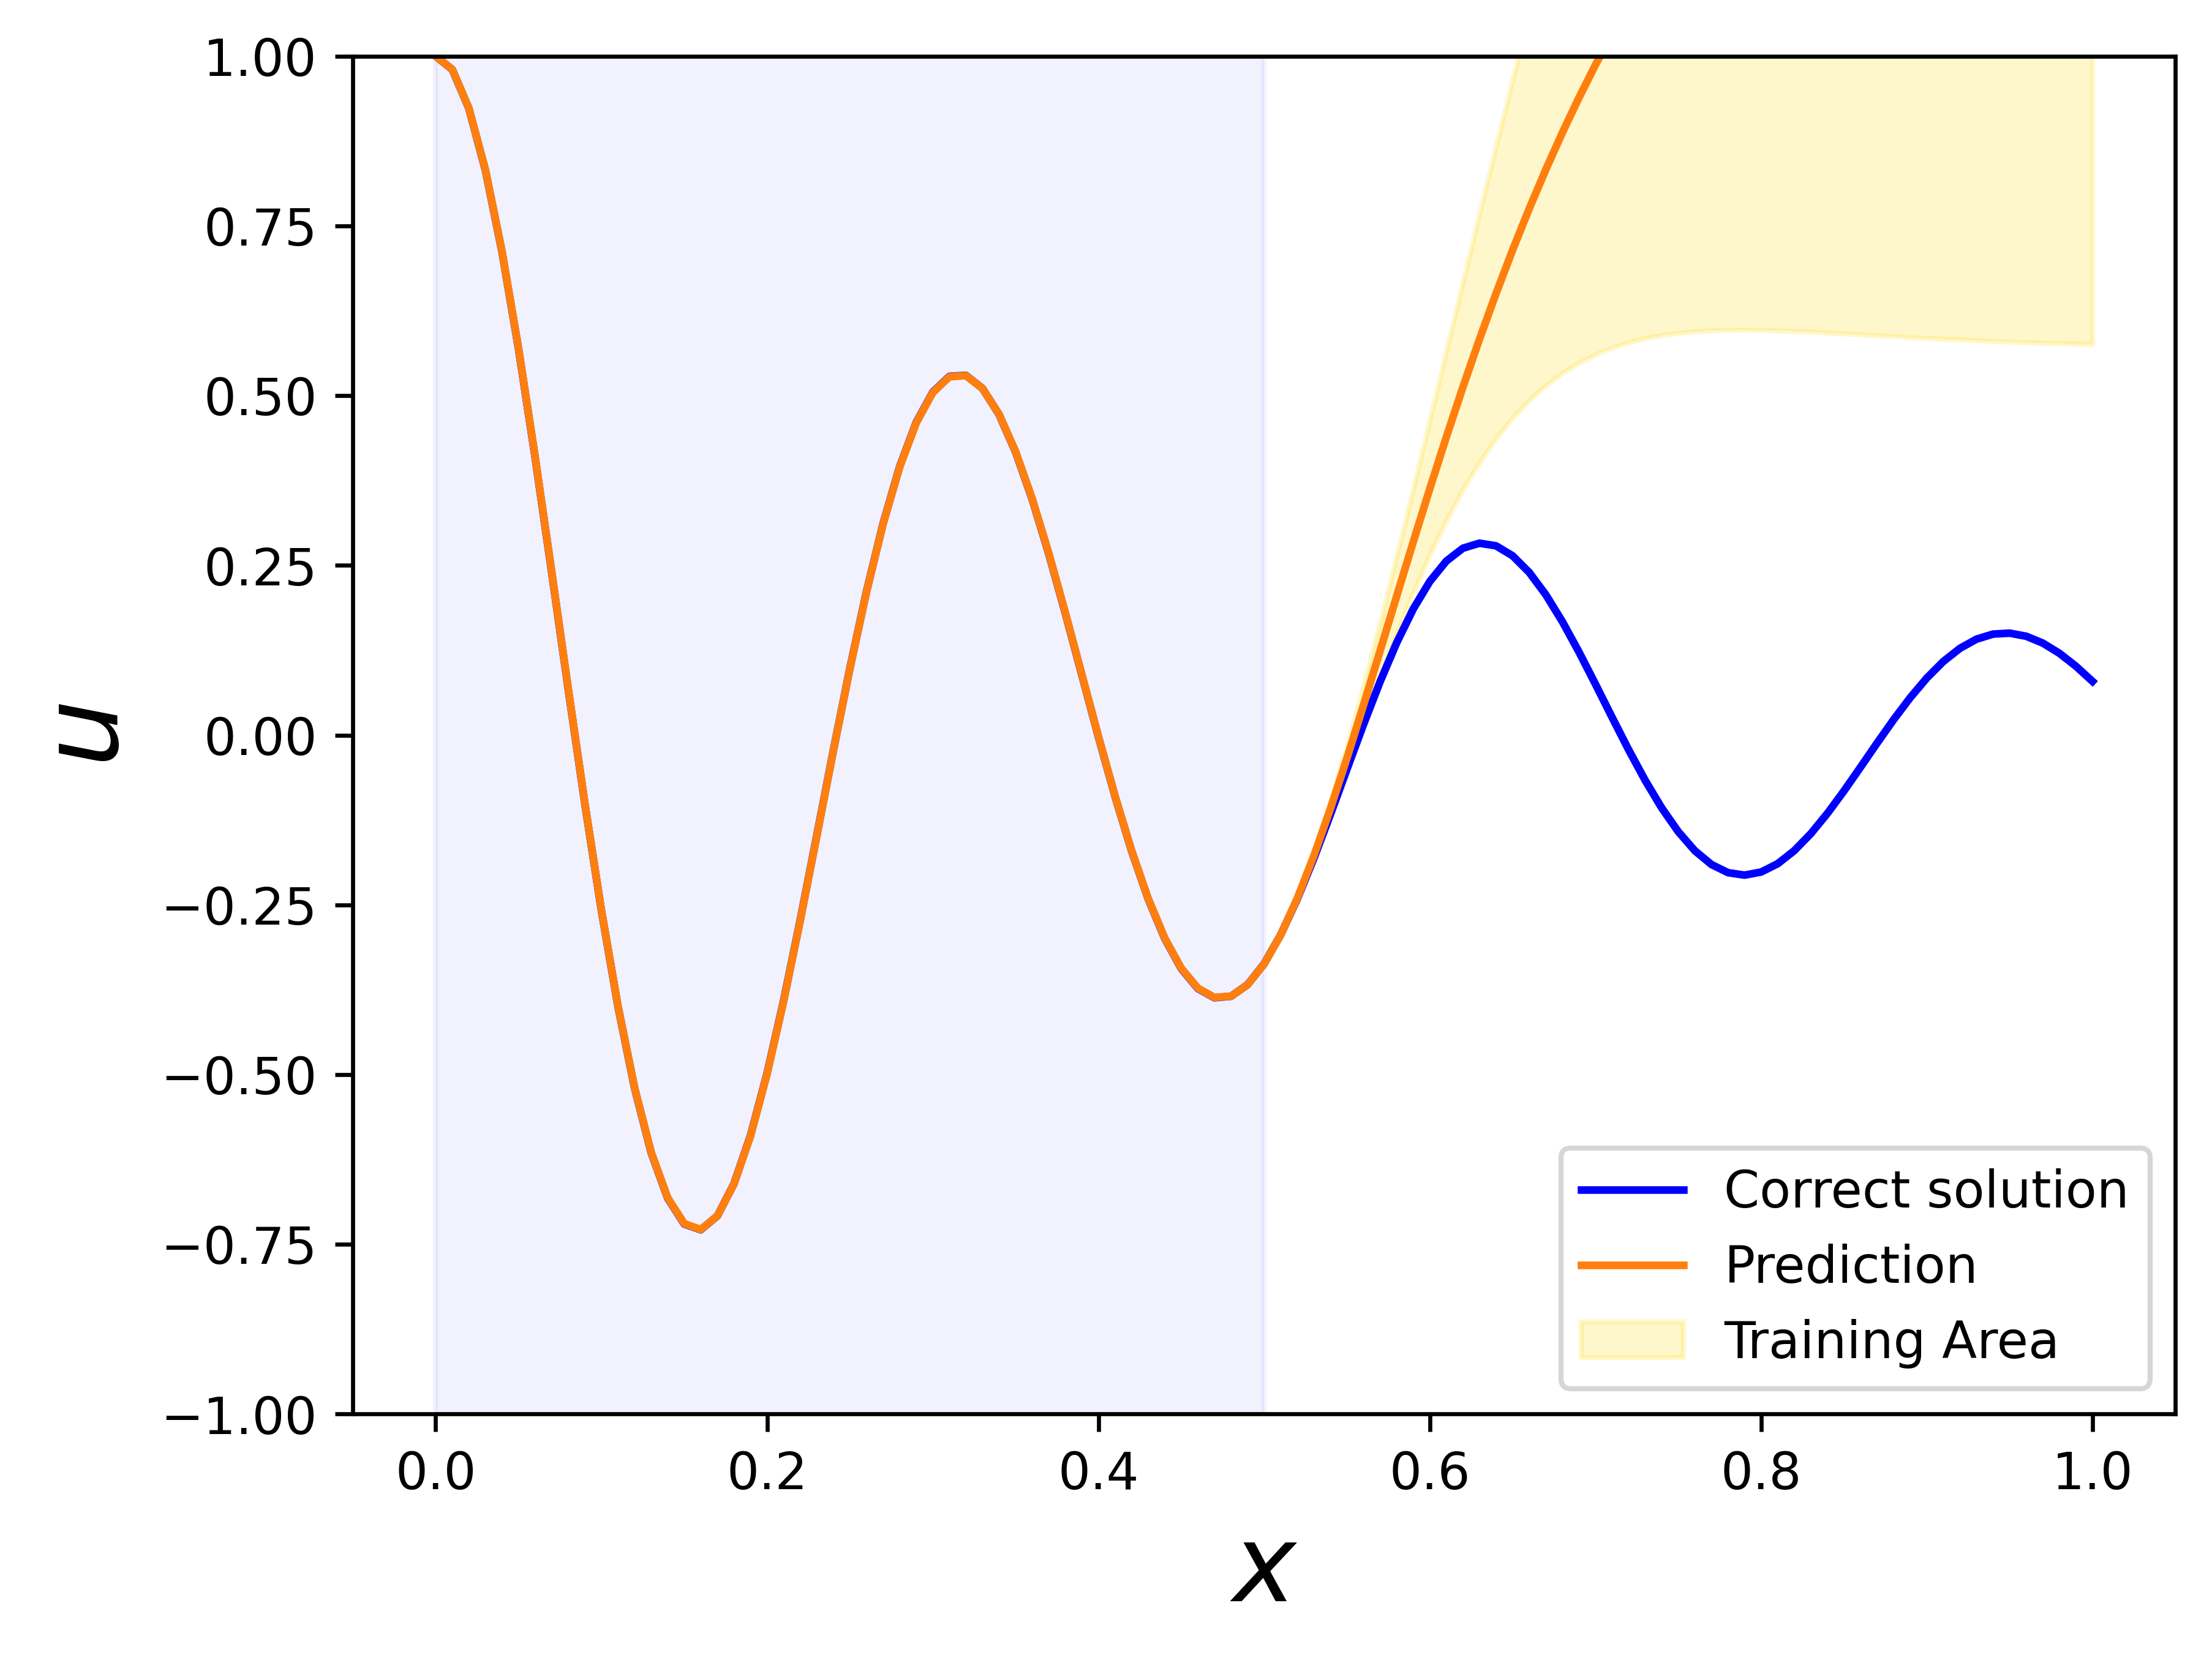

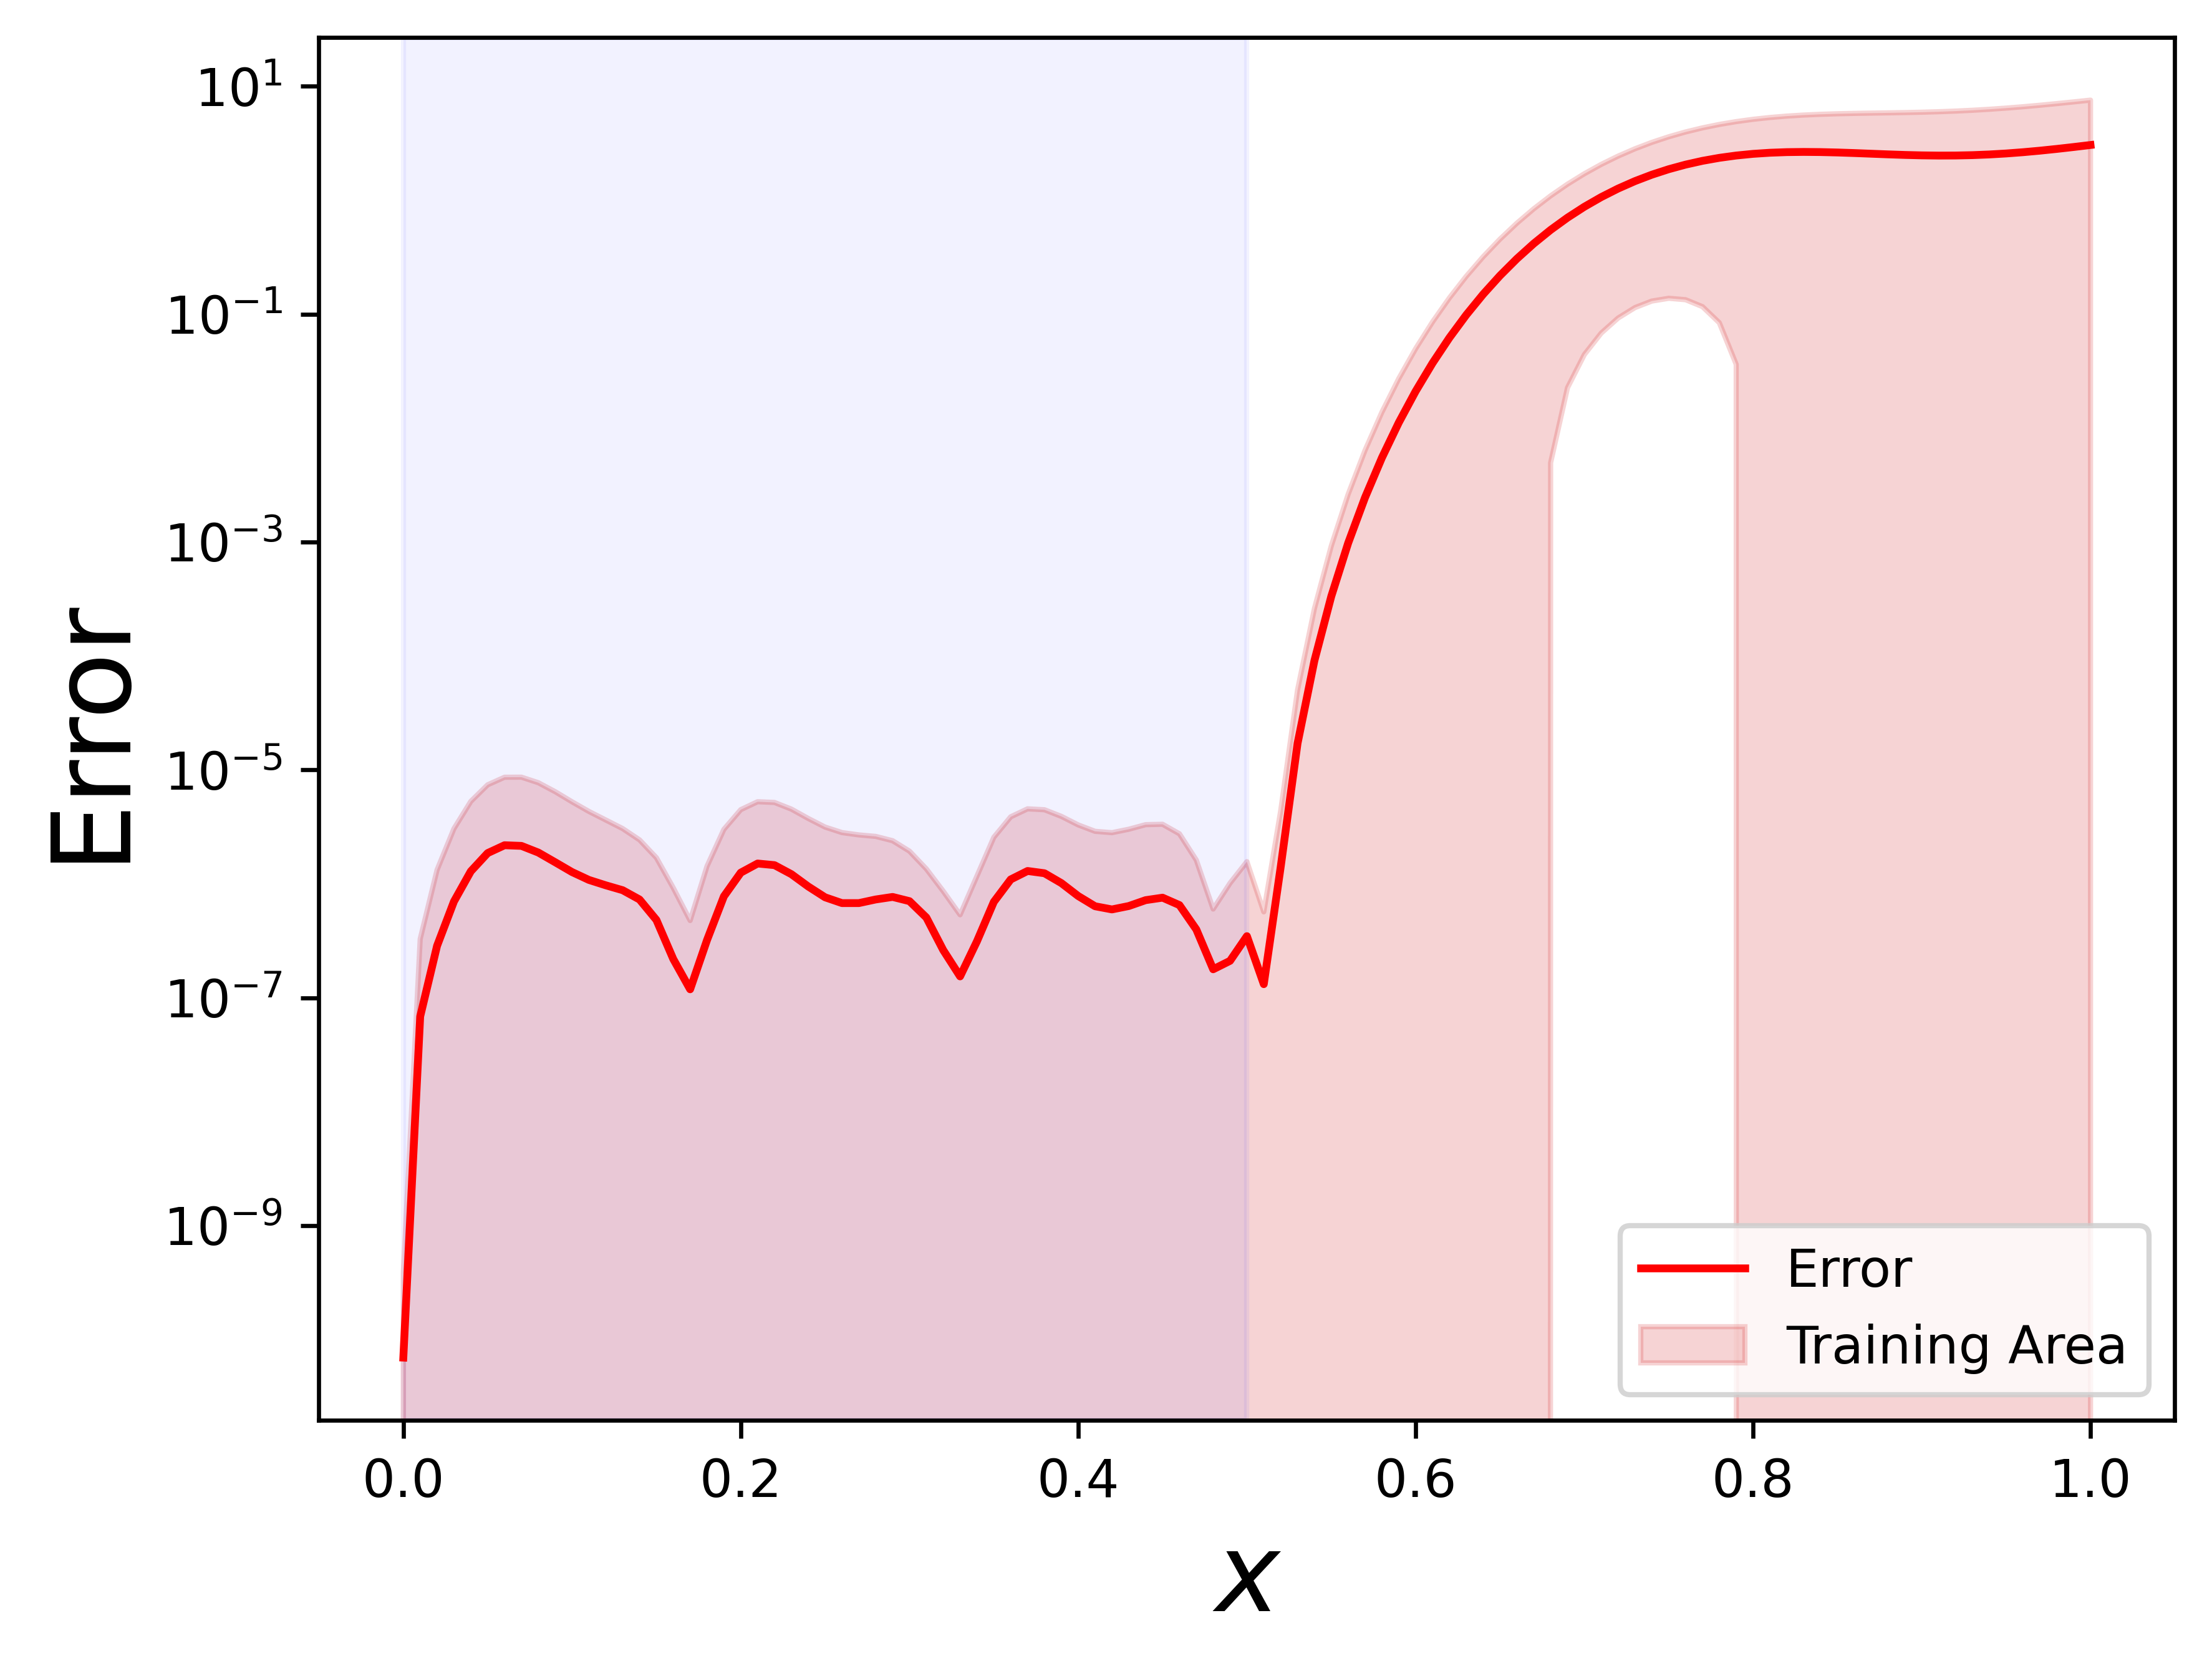

In [12]:
import torch
import torch.autograd as autograd   # computation graph
from torch.autograd import Variable
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim
import datetime, os

#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import time
#from pyDOE import lhs         #Latin Hypercube Sampling

# generates same random numbers each time
np.random.seed(1234)

n_points = 101
x = np.linspace(0.0,1.0,n_points)

lb = 0.0
ub = 0.5


d = 2.0
w0 = 20.0
mu = 2*d
k = w0**2

class oscillator(nn.Module): 
    def __init__(self, d, w0):
        super().__init__()

        self.d = d
        self.w0 = w0
        self.w = np.sqrt(self.w0**2-self.d**2)
        self.phi = np.arctan(-self.d/self.w)
        self.A = 1/(2*np.cos(self.phi))
    
    def forward(self, x):
        return 2*self.A*np.exp(-self.d*x)*np.cos(self.w*x + self.phi)
    
u_sol = oscillator(d, w0)
u = u_sol(x)
'''
def u_de(x):
    
    f_prime = 0
    f_second = 0
    f_third = 0
    f_fourth = 0
    
    for k in range(1,6):
        
        f_prime += np.cos(2*k*x)
        f_second += -2*k*np.sin(2*k*x)
        f_third += -4*(k**2)*np.cos(2*k*x)
        f_fourth += 8*(k**3)*np.sin(2*k*x)
        
    return f_prime, f_second, f_third, f_fourth

u_prime, u_second, u_third, u_fourth = u_de(x)
'''

###################
#### TEST DATA ####
###################

X_u_test = x.reshape(n_points,1)

u = u.reshape(n_points,1)



#results_name = 'left_domain_1L_50N_sin_LM'
results_name = 'Oscillator_2L_20N_LM'
split_results_name = 'left_domain_smallest_'
number_of_neurons = [10, 20, 50, 100, 200, 400]
number_of_layers = 1

time_plot_avg = np.array([0, 0, 0, 0, 0, 0])
gen_level_plot = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

time_plot_std = np.array([0, 0, 0, 0, 0, 0])



all_u_pred = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_' + results_name + '/MGP_all_U_pred_' + results_name, delimiter = ',' )
all_u_pred_x = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_prime_' + results_name + '/MGP_all_U_pred_prime_' + results_name, delimiter = ',' )

all_u_pred_xx = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_second_' + results_name + '/MGP_all_U_pred_second_' + results_name, delimiter = ',' )
all_errors = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_errors_' + results_name + '/MGP_all_U_errors_' + results_name, delimiter = ',' )

u_pred_avg = np.mean(all_u_pred, axis=1)
u_pred_std = np.std(all_u_pred, axis=1)

u_pred_x_avg = np.mean(all_u_pred_x, axis=1)
u_pred_x_std = np.std(all_u_pred_x, axis=1)

u_pred_xx_avg = np.mean(all_u_pred_xx, axis=1)
u_pred_xx_std = np.std(all_u_pred_xx, axis=1)

error_avg = np.mean(all_errors, axis=1)
error_std = np.std(all_errors, axis=1)


fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)

axs.plot(x,u, 'b')
axs.plot(X_u_test, u_pred_avg, 'tab:orange')
axs.fill_between(x, u_pred_avg - 2*u_pred_std, u_pred_avg + 2*u_pred_std, color='gold', alpha=0.2)
axs.axvspan(lb, ub, color='blue', alpha=0.05)
axs.set_xlabel(r'$x$', fontdict={'fontsize': 21})
axs.set_ylabel(r'$u$', fontdict={'fontsize': 21})
#axs.set_title('Solution $u$ of Poisson Equation', fontdict={'fontsize': 13})
axs.legend(['Correct solution','Prediction', 'Training Area'])
axs.set_ylim(-1,1)
#plt.savefig('Results/Figures/Reproducible/publi/MultiGenPINN_solution_' + results_name + '.pdf', bbox_inches = 'tight')


'''

fig, axs = plt.subplots(nrows=1, ncols=1)

axs.plot(x,u_prime, 'b')
axs.plot(X_u_test,u_pred_x_avg, 'tab:orange')
axs.fill_between(x, u_pred_x_avg - 2*u_pred_x_std, u_pred_x_avg + 2*u_pred_x_std, color='gold', alpha=0.2 )
axs.axvspan(lb, ub, color='blue', alpha=0.05)
axs.set_xlabel(r'$x$')
axs.set_ylabel(r'$du/dx$')
#axs.set_title('First derivative $u\'$', fontdict={'fontsize': 13})
axs.legend(['Correct solution','Prediction', 'Training Area'])
axs.set_ylim(-2,6)
plt.savefig('Results/Figures/Reproducible/publi/MultiGenPINN_dprime_' + results_name + '.pdf', bbox_inches = 'tight')



fig, axs = plt.subplots(nrows=1, ncols=1)

axs.plot(x,u_second, 'b')
axs.plot(X_u_test,u_pred_xx_avg, 'tab:orange')
axs.fill_between(x, u_pred_xx_avg - 2*u_pred_xx_std, u_pred_xx_avg + 2*u_pred_xx_std, color='gold', alpha=0.2 )
axs.axvspan(lb, ub, color='blue', alpha=0.05)
axs.set_xlabel(r'$x$', fontdict={'fontsize': 21})
axs.set_ylabel(r'$d^2 u/dx^2$', fontdict={'fontsize': 21})
#axs.set_title('Second derivative $u\'\'$', fontdict={'fontsize': 13})
axs.legend(['Correct solution','Prediction', 'Training Area'])
axs.set_ylim(-30,30)
plt.savefig('Results/Figures/Reproducible/publi/MultiGenPINN_dsecond_' + results_name + '.pdf', bbox_inches = 'tight')

'''

fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)

axs.plot(x, error_avg, 'r')
axs.fill_between(x, error_avg - 2*error_std, error_avg + 2*error_std, color='tab:red', alpha=0.2 )
axs.axvspan(lb, ub, color='blue', alpha=0.05)
axs.set_xlabel(r'$x$', fontdict={'fontsize': 21})
axs.set_ylabel(r'Error', fontdict={'fontsize': 21})
axs.set_yscale('log')
#axs.set_title('Prediction Error', fontdict={'fontsize': 13})
axs.legend(['Error','Training Area'])
#axs.set_ylim(-1800,1800)

#plt.savefig('Results/Figures/Reproducible/publi/MultiGenPINN_error_' + results_name + '.pdf', bbox_inches = 'tight')

Yeah!


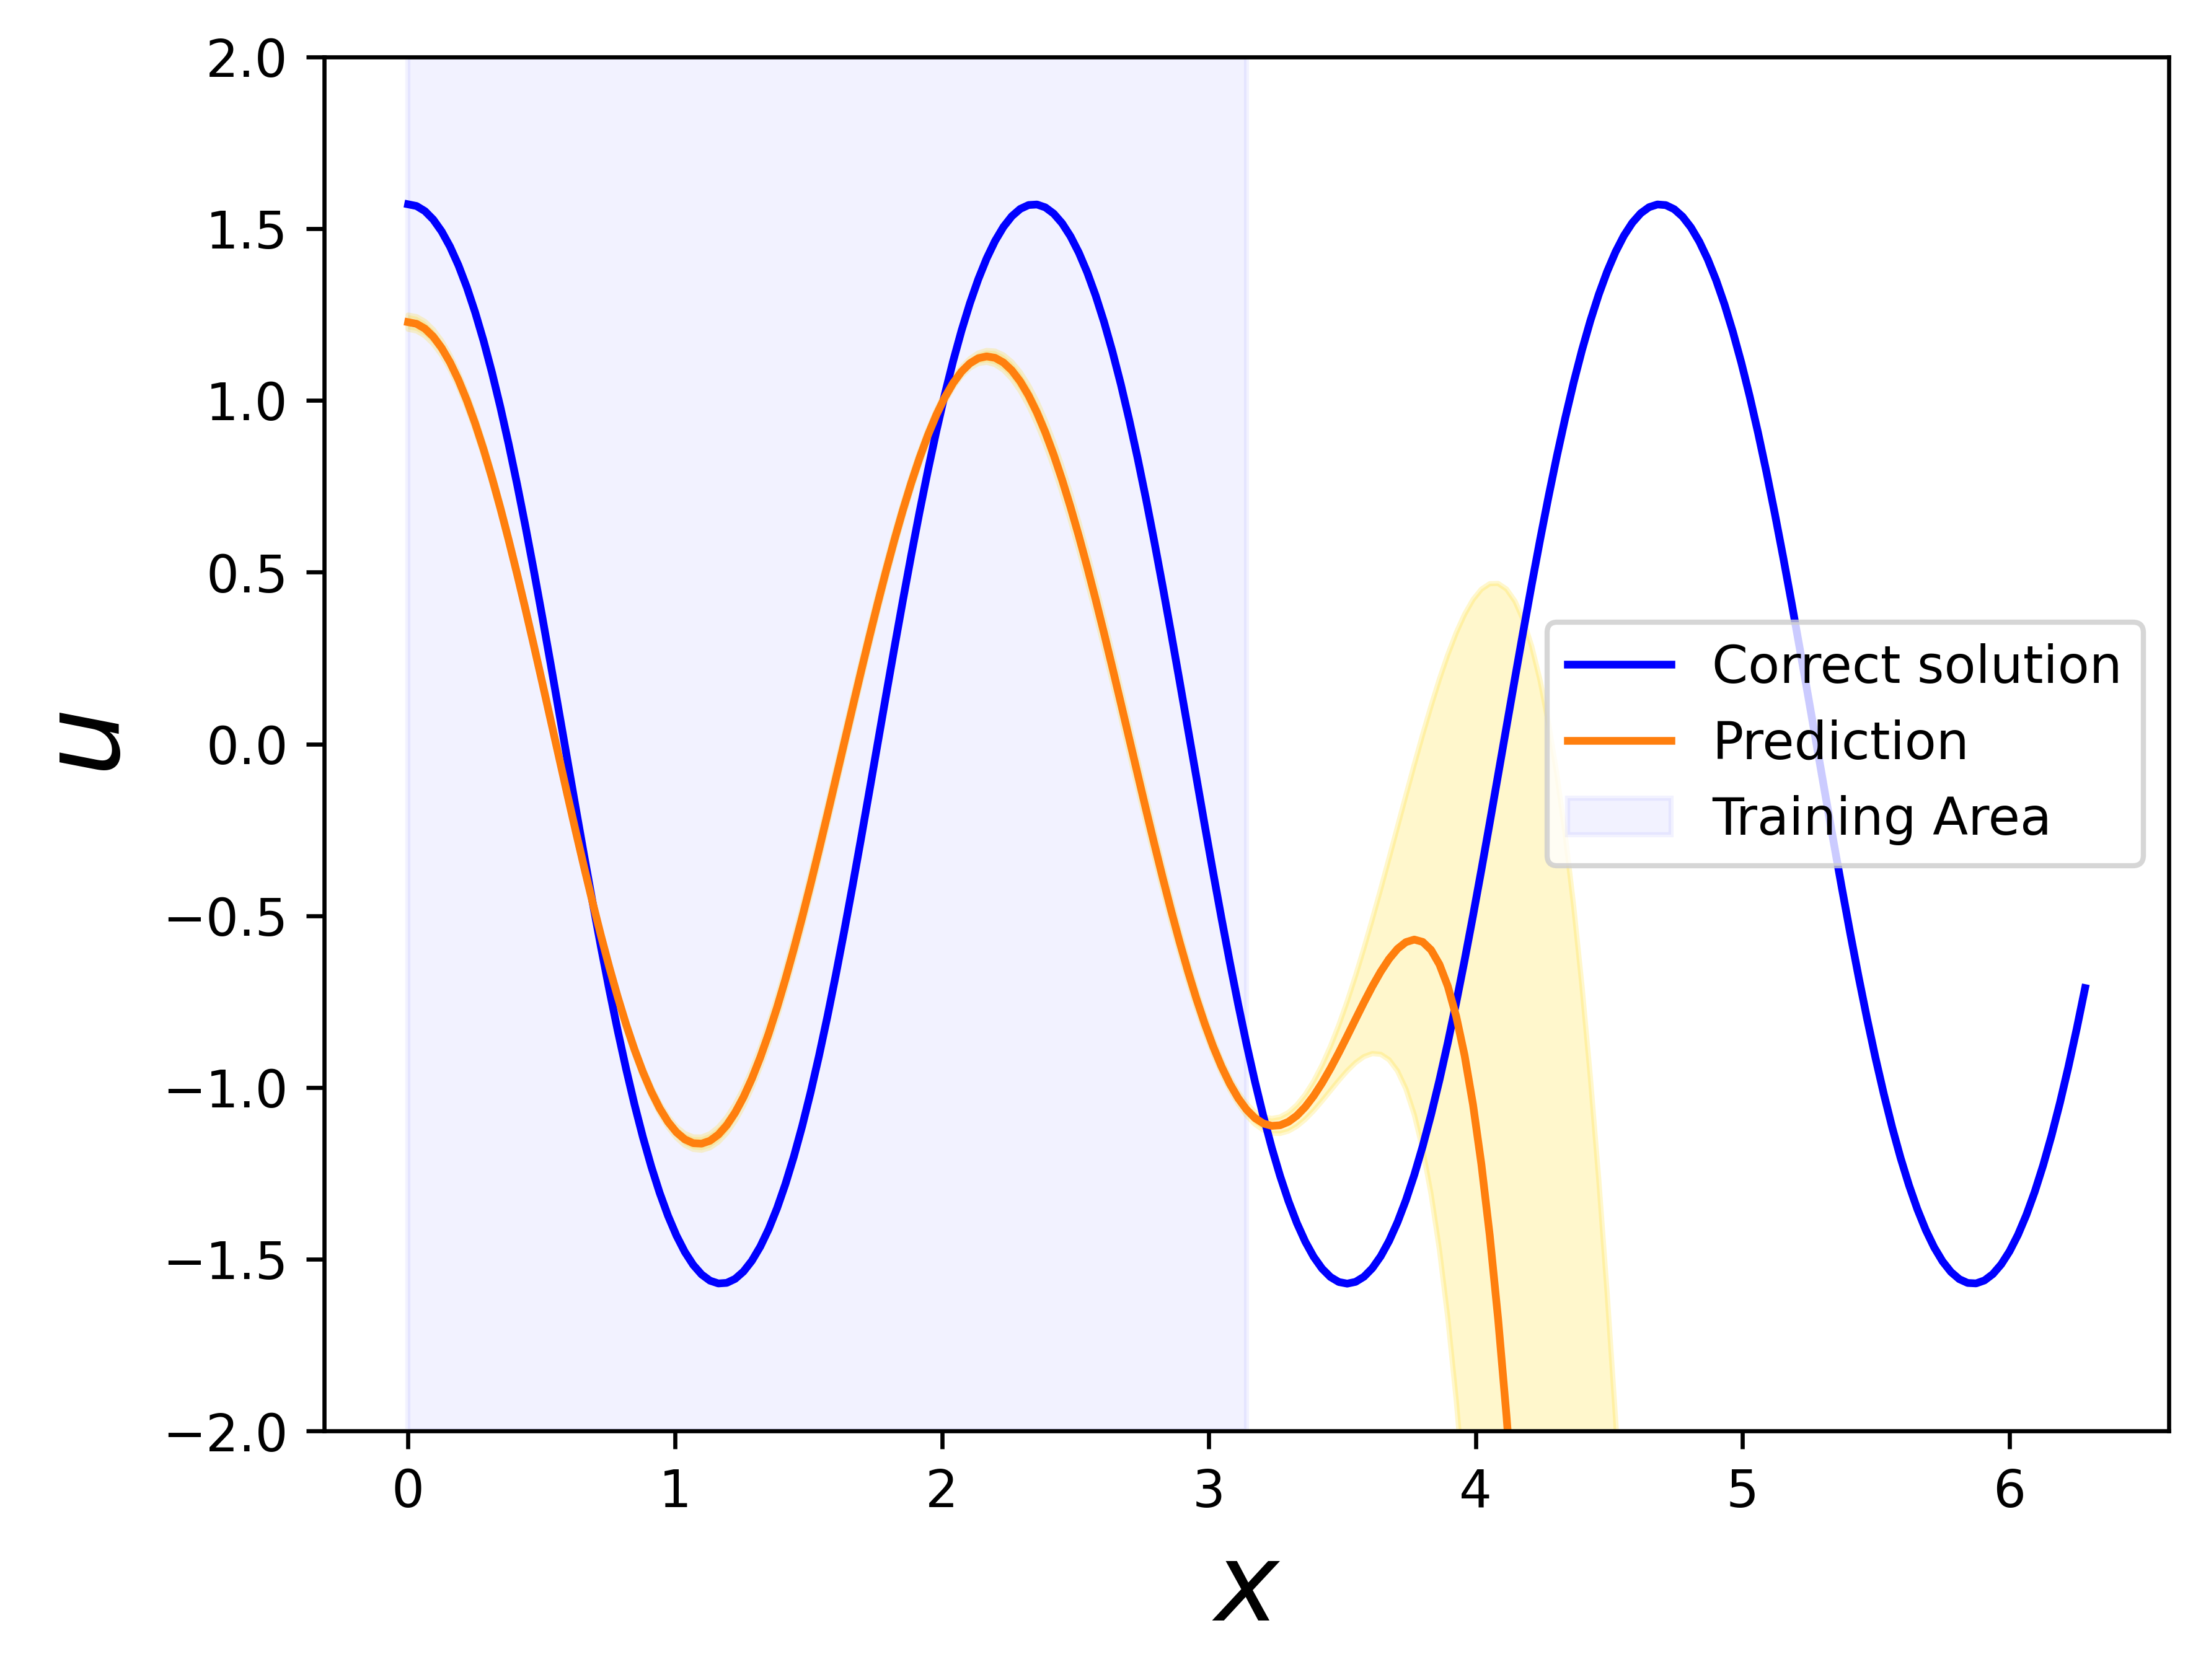

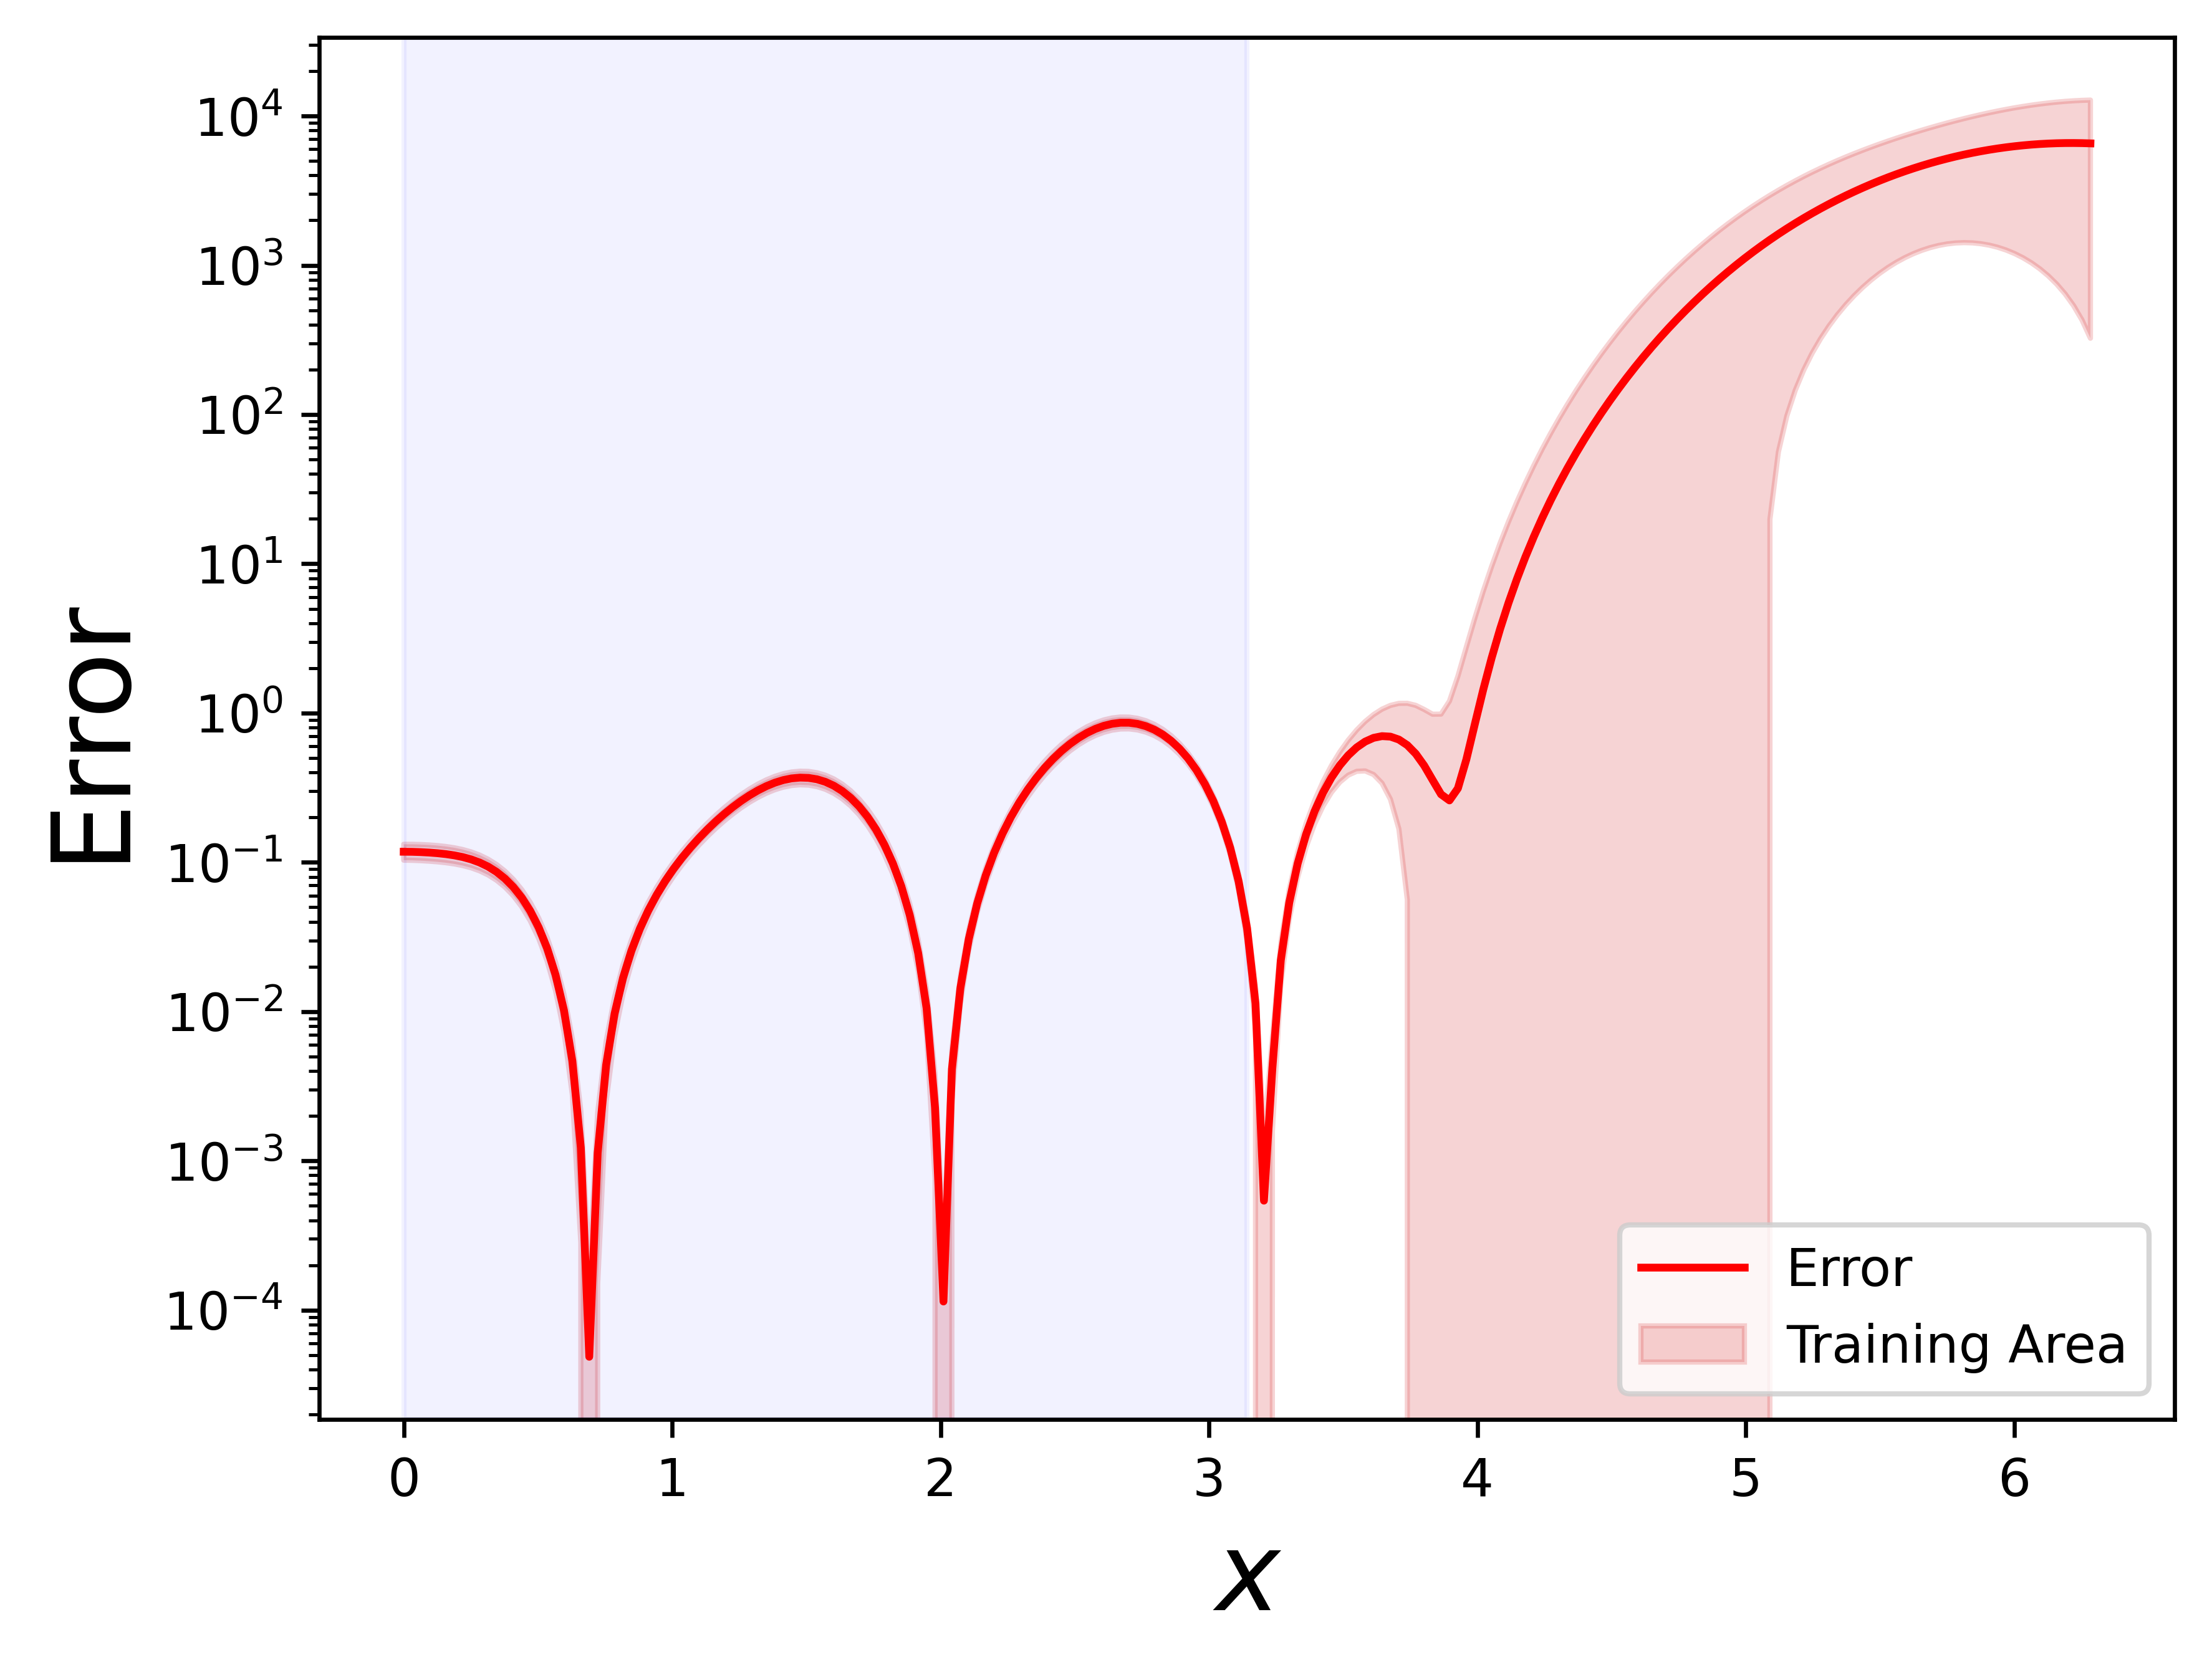

In [2]:
import torch
import torch.autograd as autograd   # computation graph
from torch.autograd import Variable
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim
import datetime, os

#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import time
import scipy.special as ss
#from pyDOE import lhs         #Latin Hypercube Sampling

# generates same random numbers each time
np.random.seed(1234)

n_points = 201
x = np.linspace(0.0,2*np.pi,n_points)

lb = 0.0
ub = np.pi


def u_sol(x):
    sn, cn, dn, ph = ss.ellipj(np.sqrt(10)*x, 0.5)
    cd = cn/dn
    return 2*np.arcsin(cd/np.sqrt(2.0))
    #return (np.sqrt(2))*np.cos(ph)
        
u = u_sol(x)

def u_de(x):
    f = 2*np.pi
    return f*np.cos(f*x), -(f**2)*np.sin(f*x), -(f**3)*np.cos(f*x), (f**4)*np.sin(f*x)

u_prime, u_second, u_third, u_fourth = u_de(x)



###################
#### TEST DATA ####
###################

X_u_test = x.reshape(n_points,1)

u = u.reshape(n_points,1)



results_name = 'Nonlinear_1L_50N_sin_LM'
#results_name = 'Oscillator_1L_50N_Adam'
split_results_name = 'left_domain_smallest_'
number_of_neurons = [10, 20, 50, 100, 200, 400]
number_of_layers = 1

time_plot_avg = np.array([0, 0, 0, 0, 0, 0])
gen_level_plot = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

time_plot_std = np.array([0, 0, 0, 0, 0, 0])



all_u_pred = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_' + results_name + '/MGP_all_U_pred_' + results_name, delimiter = ',' )
all_u_pred_x = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_prime_' + results_name + '/MGP_all_U_pred_prime_' + results_name, delimiter = ',' )

all_u_pred_xx = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_second_' + results_name + '/MGP_all_U_pred_second_' + results_name, delimiter = ',' )
all_errors = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_errors_' + results_name + '/MGP_all_U_errors_' + results_name, delimiter = ',' )

u_pred_avg = np.mean(all_u_pred, axis=1)
u_pred_std = np.std(all_u_pred, axis=1)

u_pred_x_avg = np.mean(all_u_pred_x, axis=1)
u_pred_x_std = np.std(all_u_pred_x, axis=1)

u_pred_xx_avg = np.mean(all_u_pred_xx, axis=1)
u_pred_xx_std = np.std(all_u_pred_xx, axis=1)

error_avg = np.mean(all_errors, axis=1)
error_std = np.std(all_errors, axis=1)


#plt.style.use('seaborn')
#width = 345
'''
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
'''
#plt.rcParams.update(tex_fonts)

#def u_sol(x):
#    _, cd, _, _ = ss.ellipj(np.sqrt(10)*x, 0.5) 
#    return 2*np.arcsin(cd/np.sqrt(2.0))




fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)

axs.plot(x,u, 'b')
axs.plot(X_u_test, u_pred_avg, 'tab:orange')
axs.axvspan(lb, ub, color='blue', alpha=0.05)
axs.fill_between(x, u_pred_avg - 2*u_pred_std, u_pred_avg + 2*u_pred_std, color='gold', alpha=0.2)
axs.set_xlabel(r'$x$', fontdict={'fontsize': 21})
axs.set_ylabel(r'$u$', fontdict={'fontsize': 21})
#axs.set_title('Solution $u$ of Poisson Equation', fontdict={'fontsize': 13})
axs.legend(['Correct solution','Prediction', 'Training Area'])
axs.set_ylim(-2.0,2.0)
#plt.savefig('Results/Figures/MultiGenPINN_solution_' + results_name + '.pdf', bbox_inches = 'tight')


'''

fig, axs = plt.subplots(nrows=1, ncols=1)

axs.plot(x,u_prime, 'b')
axs.plot(X_u_test,u_pred_x_avg, 'tab:orange')
axs.fill_between(x, u_pred_x_avg - 2*u_pred_x_std, u_pred_x_avg + 2*u_pred_x_std, color='gold', alpha=0.2 )
axs.axvspan(lb, ub, color='blue', alpha=0.05)
axs.set_xlabel(r'$x$')
axs.set_ylabel(r'$du/dx$')
#axs.set_title('First derivative $u\'$', fontdict={'fontsize': 13})
axs.legend(['Correct solution','Prediction', 'Training Area'])
axs.set_ylim(-2,6)
plt.savefig('Results/Figures/Reproducible/publi/MultiGenPINN_dprime_' + results_name + '.pdf', bbox_inches = 'tight')



fig, axs = plt.subplots(nrows=1, ncols=1)

axs.plot(x,u_second, 'b')
axs.plot(X_u_test,u_pred_xx_avg, 'tab:orange')
axs.fill_between(x, u_pred_xx_avg - 2*u_pred_xx_std, u_pred_xx_avg + 2*u_pred_xx_std, color='gold', alpha=0.2 )
axs.axvspan(lb, ub, color='blue', alpha=0.05)
axs.set_xlabel(r'$x$', fontdict={'fontsize': 21})
axs.set_ylabel(r'$d^2 u/dx^2$', fontdict={'fontsize': 21})
#axs.set_title('Second derivative $u\'\'$', fontdict={'fontsize': 13})
axs.legend(['Correct solution','Prediction', 'Training Area'])
axs.set_ylim(-30,30)
plt.savefig('Results/Figures/Reproducible/publi/MultiGenPINN_dsecond_' + results_name + '.pdf', bbox_inches = 'tight')

'''

fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)

axs.plot(x, error_avg, 'r')
axs.fill_between(x, error_avg - 2*error_std, error_avg + 2*error_std, color='tab:red', alpha=0.2 )
axs.axvspan(lb, ub, color='blue', alpha=0.05)
axs.set_xlabel(r'$x$', fontdict={'fontsize': 21})
axs.set_ylabel(r'Error', fontdict={'fontsize': 21})
axs.set_yscale('log')
#axs.set_title('Prediction Error', fontdict={'fontsize': 13})
axs.legend(['Error','Training Area'])
#axs.set_ylim(-1800,1800)

#plt.savefig('Results/Figures/Reproducible/publi/MultiGenPINN_error_' + results_name + '.pdf', bbox_inches = 'tight')